# Imports, Helper Functions, and Loading

In [1]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import healpy as hp

import lsst.daf.butler as dafButler

# if you are running latest daily, May 13 (setup lsst_distrib -t d_latest) you should have analysis_ap
# within lsst_distrib

# it was merged as  this ticket 
# https://rubinobs.atlassian.net/browse/DM-44157 

# if you do not have analysis_ap package, you need to github clone and
# setup it in your environment, for instance
# setup -k -r /sdf/home/n/ncaplar/github/analysis_ap

from lsst.analysis.ap import apdb
from lsst.daf.butler import DataCoordinate
from lsst.obs.lsst import RubinDimensionPacker
from lsst.ap.association import AssociationTask, AssociationConfig

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

plt.set_loglevel('WARNING')

INFO:numexpr.utils:Note: detected 128 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 128 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [3]:
repo = '/repo/embargo'
instrument = 'LSSTComCamSim'

# previous run:
# uses ccdVisitId, not (ccd, visitId)!
# collections = 'u/elhoward/DM-43098/LSSTComCamSim'
# schema = f'elhoward_dm43098_lsstcomcamsim_appipe'

# run done over the weekend May11/May12:
# these do not use ccdVisitId!
collections = 'u/elhoward/DM-44138/LSSTComCamSim'
schema =  f'elhoward_dm44138_LSSTComCamSim'


butler = dafButler.Butler(repo, instrument=instrument)
registry = butler.registry
skymap = butler.get("skyMap", collections=collections, skymap="ops_rehersal_prep_2k_v1")
apdbQuery = apdb.ApdbPostgresQuery(instrument=instrument, namespace=schema)

In [4]:
# This is to see all of the columns avaliable
with apdbQuery.connection as connection:
    # Query to fetch all column names from the DiaObject table
    query_columns = '''
    SELECT column_name
    FROM information_schema.columns
    WHERE table_schema = 'elhoward_dm44138_LSSTComCamSim' AND table_name = 'DiaSource';
    '''
    df_columns = pd.read_sql_query(query_columns, connection)
    print("Available columns:", df_columns['column_name'].tolist())

Available columns: ['diaSourceId', 'visit', 'detector', 'diaObjectId', 'ssObjectId', 'parentDiaSourceId', 'ssObjectReassocTime', 'midpointMjdTai', 'ra', 'raErr', 'dec', 'decErr', 'ra_dec_Cov', 'x', 'xErr', 'y', 'yErr', 'x_y_Cov', 'centroid_flag', 'apFlux', 'apFluxErr', 'apFlux_flag', 'apFlux_flag_apertureTruncated', 'snr', 'psfFlux', 'psfFluxErr', 'psfRa', 'psfRaErr', 'psfDec', 'psfDecErr', 'psfFlux_psfRa_Cov', 'psfFlux_psfDec_Cov', 'psfRa_psfDec_Cov', 'psfLnL', 'psfChi2', 'psfNdata', 'psfFlux_flag', 'psfFlux_flag_edge', 'psfFlux_flag_noGoodPixels', 'trailFlux', 'trailFluxErr', 'trailRa', 'trailRaErr', 'trailDec', 'trailDecErr', 'trailLength', 'trailLengthErr', 'trailAngle', 'trailAngleErr', 'trailFlux_trailRa_Cov', 'trailFlux_trailDec_Cov', 'trailFlux_trailLength_Cov', 'trailFlux_trailAngle_Cov', 'trailRa_trailDec_Cov', 'trailRa_trailLength_Cov', 'trailRa_trailAngle_Cov', 'trailDec_trailLength_Cov', 'trailDec_trailAngle_Cov', 'trailLength_trailAngle_Cov', 'trailLnL', 'trailChi2', 'tra

In [5]:
# just a small cell showing number of observations in different parts of the sky

## Grouping tracts based on location on the sky
group1 = [3384, 3385]
group2 = [2261, 2262, 2494, 2495]
group3 = [9880, 9881, 9638]
group4 = [3533, 3534, 3345, 3346]
group5 = [7683, 7684, 7445, 7446]
group6 = [9590, 9591, 9347, 9348]
group7 = [9812, 9813]
group8 = [7149, 6914, 6915]

groups = [group1, group2, group3, group4, group5, group6, group7, group8]

def getUniqueVisits(collections, tracts):
    """Get the unique visits from a given tract."""
    visitList = []
    tracts = ','.join(str(tract) for tract in tracts)
    for d in sorted(registry.queryDatasets(datasetType="goodSeeingDiff_diaSrcTable", collections=collections, \
        where=f"skymap='ops_rehersal_prep_2k_v1' AND tract IN ({tracts})")): 
        visitList.append(d.dataId['visit'])
    uniqueVisits = list(set(visitList))
    return uniqueVisits

visitListByGroup = []

for group in groups:
    visits = getUniqueVisits(collections, group)
    visitListByGroup.append(visits)
    print("There are "+str(len(visits))+f" visits in tracts {group}")

There are 119 visits in tracts [3384, 3385]
There are 352 visits in tracts [2261, 2262, 2494, 2495]
There are 298 visits in tracts [9880, 9881, 9638]
There are 295 visits in tracts [3533, 3534, 3345, 3346]
There are 354 visits in tracts [7683, 7684, 7445, 7446]
There are 238 visits in tracts [9590, 9591, 9347, 9348]
There are 356 visits in tracts [9812, 9813]
There are 299 visits in tracts [7149, 6914, 6915]


In [6]:
# let us look at one tract, just randomly 3533
tract_id = 3533

tractInfo = skymap.generateTract(tract_id)
tractInfo_vertices = tractInfo.vertex_list

vertices_as_deg = []
for i in range(0,4):
   vertices_as_deg.append([tractInfo_vertices[i].getRa().asDegrees(), tractInfo_vertices[i].getDec().asDegrees()])
vertices_as_deg = np.array(vertices_as_deg)

ra_min = np.min(vertices_as_deg[:,0])
ra_max = np.max(vertices_as_deg[:,0])
dec_min = np.min(vertices_as_deg[:,1])
dec_max = np.max(vertices_as_deg[:,1])

In [13]:
# let us say that we want to get all diaSources and diaObjects from this one tract
with apdbQuery.connection as connection:
    pp_source_table = pd.read_sql_query(f'SELECT "diaSourceId", "diaObjectId", "ra", "dec", "midpointMjdTai", \
        "visit", "detector", \
        "psfFlux", "psfFluxErr", \
        "scienceFlux", "scienceFluxErr", "snr", \
        "band", "time_processed", "time_withdrawn"  \
        FROM "{schema}"."DiaSource" \
        WHERE "ra" BETWEEN {ra_min} AND {ra_max} \
        AND "dec" BETWEEN {dec_min} AND {dec_max} \
        LIMIT 3000000; ''', connection)
  

with apdbQuery.connection as connection:
    pp_object_table = pd.read_sql_query(f'''SELECT "diaObjectId", "ra", "dec", "nDiaSources", \
        "validityStart", "validityEnd", "lastNonForcedSource"
        FROM "{schema}"."DiaObject"
        WHERE "ra" BETWEEN {ra_min} AND {ra_max}
        AND "dec" BETWEEN {dec_min} AND {dec_max}
        AND "validityEnd" IS NULL
        LIMIT 2000000;
        ''', connection)
    
# assert that you got all of them, i.e., that the length of the outpus is lower than the limit requested
assert (len(pp_source_table)) < 3000000
assert (len(pp_object_table)) < 2000000

# Single visit analysis

In [15]:
visit = 7024040300256
detector = 2

src_single_visit_det = pp_source_table[(pp_source_table['visit']==visit) & (pp_source_table['detector']==2)]
# let us store time of the observation for the future
midpointMjdTai = src_single_visit_det['midpointMjdTai'].values[0]
# and print out
src_single_visit_det

,diaSourceId,diaObjectId,ra,dec,midpointMjdTai,visit,detector,psfFlux,psfFluxErr,scienceFlux,scienceFluxErr,snr,band,time_processed,time_withdrawn
204264,3065473877497872410,3065438957283049591,224.508606,-39.697759,60404.126433,7024040300256,2,-3367.691059,408.967553,6.801535e+03,399.406599,8.217826,i,2024-05-09 22:54:25.157088,None
204265,3065473877497872411,3065473977347473533,224.502916,-39.752046,60404.126433,7024040300256,2,-90886.127675,478.658616,5.656299e+04,468.341653,189.856750,i,2024-05-09 22:54:25.157088,None
204266,3065473877497872413,3065473885005677276,224.514386,-39.671233,60404.126433,7024040300256,2,3384.271552,605.549984,2.197558e+05,593.624154,5.557559,i,2024-05-09 22:54:25.157088,None
204267,3065473877497872415,3065473885005677007,224.523305,-39.606829,60404.126433,7024040300256,2,12158.220190,1532.419445,1.616401e+06,1504.128297,7.791718,i,2024-05-09 22:54:25.157088,None
204268,3065473877497872416,3065509099455120313,224.504111,-39.777513,60404.126433,7024040300256,2,228766.857536,726.525839,3.649795e+05,716.349811,311.171295,i,2024-05-09 22:54:25.157088,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207578,3065473877497872403,3065473885005676948,224.516687,-39.593256,60404.126433,7024040300256,2,76046.576801,528.961669,9.750221e+04,519.557143,143.462967,i,2024-05-09 22:54:25.157088,None
207579,3065473877497872405,3065473885005676968,224.518241,-39.598104,60404.126433,7024040300256,2,5313.782752,952.955306,5.752509e+05,930.448591,5.335218,i,2024-05-09 22:54:25.157088,None
207580,3065473877497872406,3065473977347473634,224.499239,-39.767529,60404.126433,7024040300256,2,-3006.843023,394.884177,1.179059e+03,388.862537,7.644989,i,2024-05-09 22:54:25.157088,None
207581,3065473877497872407,3065473925820448788,224.504766,-39.729131,60404.126433,7024040300256,2,-49420.672061,487.119765,6.206218e+04,475.672333,101.458786,i,2024-05-09 22:54:25.157088,None


In [16]:
# this is to figure out which healpy corresponds to the observations
# figure out the center of the observations
ra_cent = np.median(src_single_visit_det['ra'])
dec_cent = np.median(src_single_visit_det['dec'])
vec = hp.ang2vec(np.deg2rad((np.abs(dec_cent) + 90)), np.deg2rad(ra_cent))
# from this you can get closet healpixels
ipix_disc = hp.query_disc(nside=32, vec=vec, radius=np.radians(1) )
# take the first value if there are more pixels found nearby 
healpix_id = ipix_disc[0]

In [17]:
# loading truth catalogs here 

# path to the truth catalogs
path_to_tru_cat = '/sdf/data/rubin/shared/ops-rehearsals/ops-rehearsal-3/imSim_catalogs/skyCatalogs/'

# loads stars, galaxies, solar system objects
df_single_ps = pd.read_parquet(path_to_tru_cat+'pointsource_'+str(healpix_id)+'.parquet')
df_single_sso = pd.read_parquet(path_to_tru_cat+'sso_'+str(healpix_id)+'.parquet')
df_single_gal = pd.read_parquet(path_to_tru_cat+'galaxy_'+str(healpix_id)+'.parquet')
# for galaxies you have to add 360 to ra because it seems to be from -180 to 180
# and others are 0 to 360
if np.median(df_single_gal['ra']) < 0: 
    df_single_gal['ra'] = df_single_gal['ra'] + 360

# find variable objects (only stars are variable in this rehersal)
df_single_ps_var = df_single_ps[df_single_ps['is_variable']==True]
df_single_ps_no_var = df_single_ps[df_single_ps['is_variable']==False]

# let us find the max and min extent of the visit
ra_min = np.min(src_single_visit_det['ra'])
ra_max = np.max(src_single_visit_det['ra'])
dec_min = np.min(src_single_visit_det['dec'])
dec_max = np.max(src_single_visit_det['dec'])


# cut the simulated objectd to the area that overlaps
df_single_ps_var_zoom = df_single_ps_var[(df_single_ps_var['ra']<ra_max) & (df_single_ps_var['ra']>ra_min) &\
    (df_single_ps_var['dec']<dec_max) & (df_single_ps_var['dec']>dec_min) ]
df_single_ps_no_var_zoom = df_single_ps_no_var[(df_single_ps_no_var['ra']<ra_max) & (df_single_ps_no_var['ra']>ra_min) &\
    (df_single_ps_no_var['dec']<dec_max) & (df_single_ps_no_var['dec']>dec_min) ]
df_single_gal_zoom = df_single_gal[(df_single_gal['ra']<ra_max) & (df_single_gal['ra']>ra_min) &\
    (df_single_gal['dec']<dec_max) & (df_single_gal['dec']>dec_min) ]

# for solar system we need more work, to get their exact positions during the observations
# this is very ineficent code
sso_ids = np.unique(df_single_sso['id'])
list_of_sso_single_exp = []
for i in range(len(sso_ids)):
    # for object, find all positions, fit as a position of the time and return
    df_single_sso_single_id = df_single_sso[df_single_sso['id']==sso_ids[i]]
    ra_fit = np.polyfit(df_single_sso_single_id['mjd'],df_single_sso_single_id['ra'], deg = 2)
    dec_fit = np.polyfit(df_single_sso_single_id['mjd'],df_single_sso_single_id['dec'], deg = 2)
    ra_poly = np.poly1d(ra_fit)
    dec_poly = np.poly1d(dec_fit)

    # Predicting values
    predicted_ra = ra_poly(midpointMjdTai)
    predicted_dec = dec_poly(midpointMjdTai)
    list_of_sso_single_exp.append([sso_ids[i], predicted_ra, predicted_dec])
    
array_of_sso_single_exp = np.array(list_of_sso_single_exp)
df_single_sso = pd.DataFrame(array_of_sso_single_exp, columns=['id', 'ra', 'dec'])
df_single_sso['ra'] = df_single_sso['ra'].astype(float)
df_single_sso['dec'] = df_single_sso['dec'].astype(float)    
    
df_single_sso_zoom = df_single_sso[(df_single_sso['ra']<ra_max) & (df_single_sso['ra']>ra_min) &\
    (df_single_sso['dec']<dec_max) & (df_single_sso['dec']>dec_min) ]

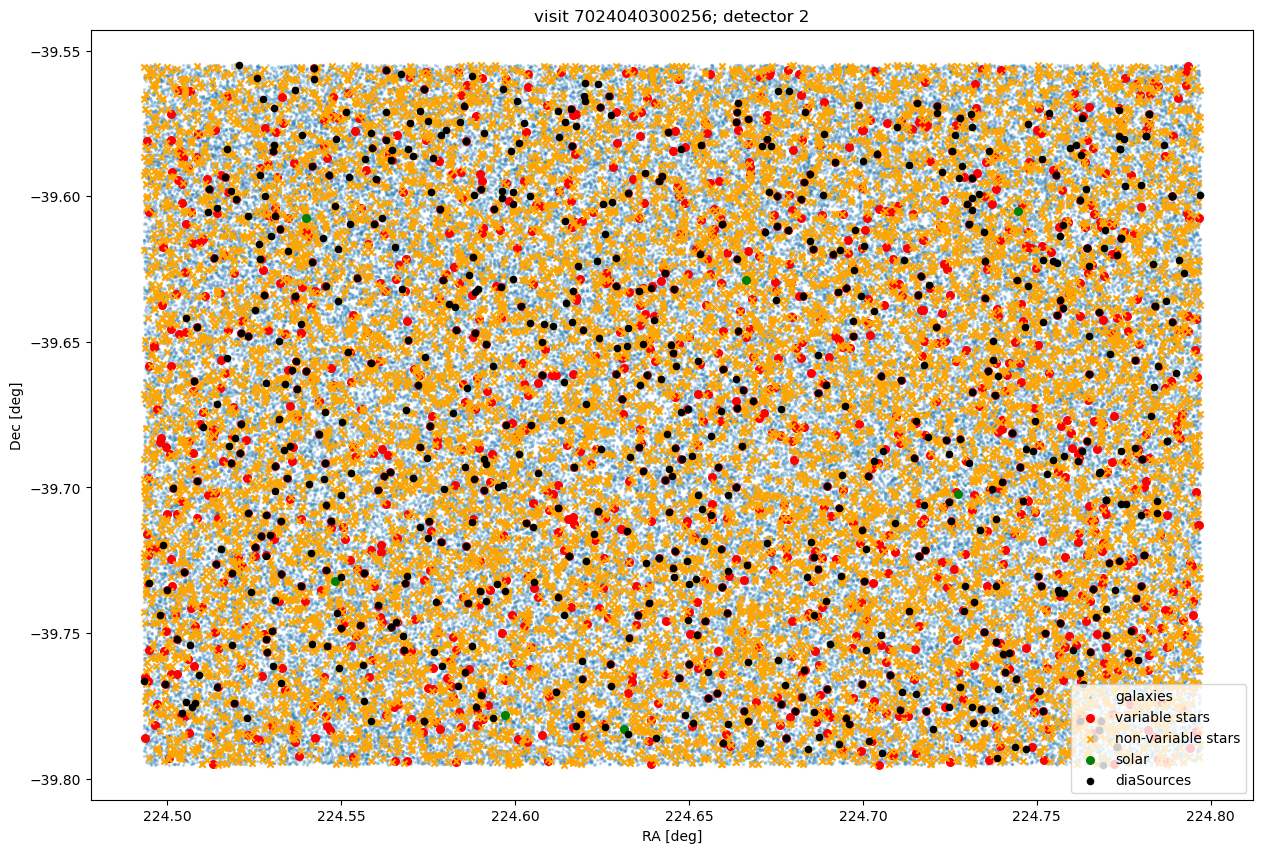

In [20]:
plt.figure(figsize=(15,10))

plt.scatter(df_single_gal_zoom['ra'], df_single_gal_zoom['dec'], s=2, alpha=0.21, label = 'galaxies')
plt.scatter(df_single_ps_var_zoom['ra'], df_single_ps_var_zoom['dec'], s=30, alpha=1, label = 'variable stars', color = 'red', marker='o')
plt.scatter(df_single_ps_no_var_zoom['ra'], df_single_ps_no_var_zoom['dec'], s=20, alpha=1, label = 'non-variable stars', color = 'orange', marker='x')
plt.scatter(df_single_sso_zoom['ra'], df_single_sso_zoom['dec'], s=30, alpha=1, label = 'solar', color ='green')
plt.scatter(src_single_visit_det['ra'], src_single_visit_det['dec'], s=20, alpha=1, label = 'diaSources', color ='black')
plt.xlabel('RA [deg]')
plt.ylabel('Dec [deg]')
plt.title('visit '+str(visit)+'; detector '+str(detector))
plt.legend()

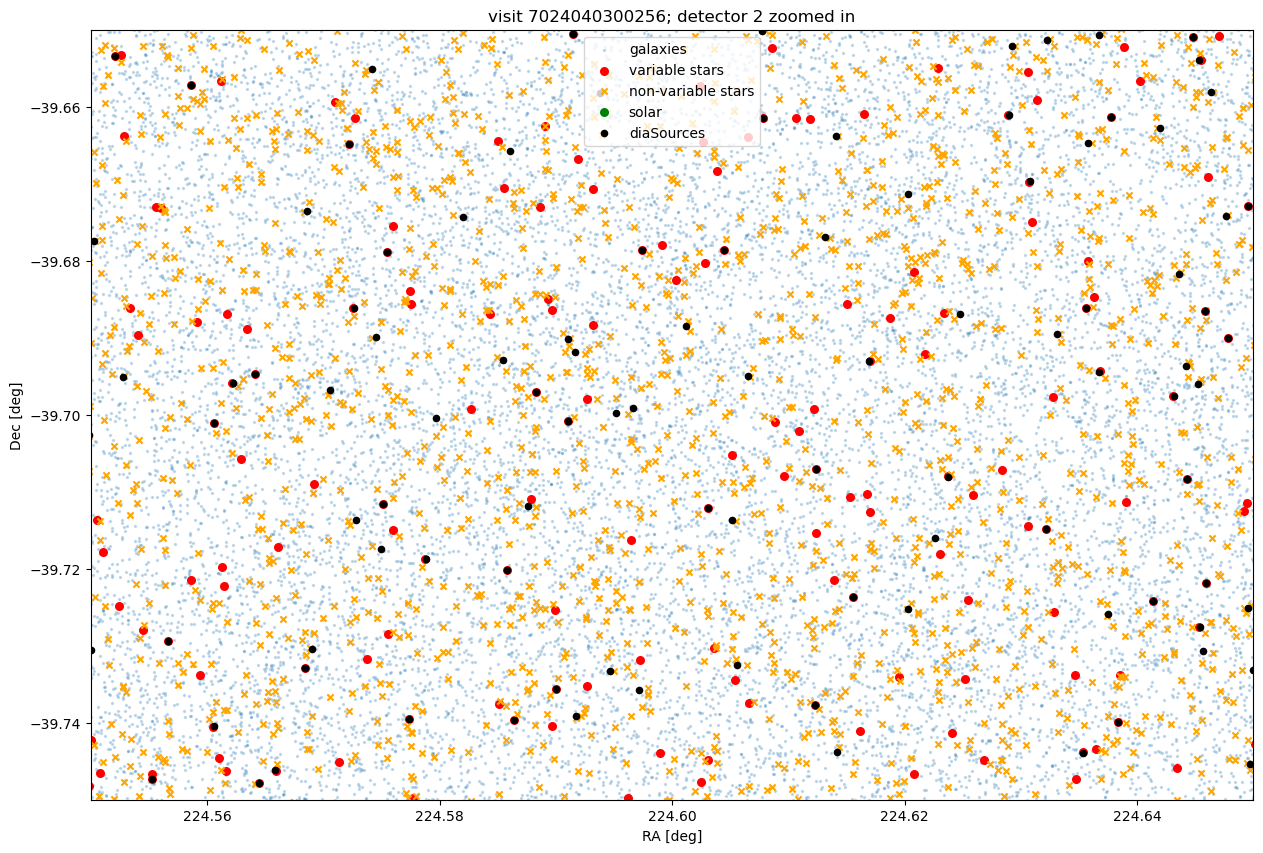

In [21]:
plt.figure(figsize=(15,10))

plt.scatter(df_single_gal_zoom['ra'], df_single_gal_zoom['dec'], s=2, alpha=0.21, label = 'galaxies')
plt.scatter(df_single_ps_var_zoom['ra'], df_single_ps_var_zoom['dec'], s=30, alpha=1, label = 'variable stars', color = 'red', marker='o')
plt.scatter(df_single_ps_no_var_zoom['ra'], df_single_ps_no_var_zoom['dec'], s=20, alpha=1, label = 'non-variable stars', color = 'orange', marker='x')
plt.scatter(df_single_sso_zoom['ra'], df_single_sso_zoom['dec'], s=30, alpha=1, label = 'solar', color ='green')
plt.scatter(src_single_visit_det['ra'], src_single_visit_det['dec'], s=20, alpha=1, label = 'diaSources', color ='black')
plt.legend()
plt.xlim(224.55, 224.65)
plt.ylim(-39.75, -39.65)
plt.xlabel('RA [deg]')
plt.ylabel('Dec [deg]')
plt.title('visit '+str(visit)+'; detector '+str(detector)+' zoomed in')
plt.legend()

In [13]:
# Possible improvments: 
# cut on magnitude here? example 
# call butler to show the image?
# given diaSource give me everything in the true Table within 1 arcSec? some basic crossmatching - matcher in the stack, association.py, lsst.ap, associations task (see below )

# Matching via association matcher - not finished!

In [109]:
import smatch

nside=4096 # healpix nside
maxmatch=1 # return closest match

ra1 = src_single_visit_det['ra'].values
dec1 = src_single_visit_det['dec'].values

ra2 = df_single_gal_zoom['ra'].values
dec2 = df_single_gal_zoom['dec'].values

radius = 1



# ra,dec,radius in degrees
matches = smatch.match(ra1, dec1, radius, ra2, dec2,
                       nside=nside, maxmatch=maxmatch)

matches


array([(  0, 116227, 1.), (  1,  92801, 1.), (  2,  49945, 1.),
       (  3,  69984, 1.), (  4,   1484, 1.), (  5,  95822, 1.),
       (  6,  58330, 1.), (  7,  96150, 1.), (  8,  80773, 1.),
       (  9, 116571, 1.), ( 10, 106658, 1.), ( 11, 108585, 1.),
       ( 12, 109689, 1.), ( 13,  16798, 1.), ( 14,  78194, 1.),
       ( 15,  84637, 1.), ( 16,  13274, 1.), ( 17,  71054, 1.),
       ( 18,  24588, 1.), ( 19,  52779, 1.), ( 20, 103193, 1.),
       ( 21,  57015, 1.), ( 22,  17770, 1.), ( 23,  62747, 1.),
       ( 24,  40946, 1.), ( 25,  31538, 1.), ( 26,  11973, 1.),
       ( 27,  34801, 1.), ( 28,  18018, 1.), ( 29,  40391, 1.),
       ( 30,   1626, 1.), ( 31, 107016, 1.), ( 32,  28479, 1.),
       ( 33,  78492, 1.), ( 34,  53658, 1.), ( 35,   4139, 1.),
       ( 36,  52501, 1.), ( 37, 115059, 1.), ( 38,  76061, 1.),
       ( 39,  91648, 1.), ( 40,  25511, 1.), ( 41,  63010, 1.),
       ( 42,  15489, 1.), ( 43,  85271, 1.), ( 44, 107271, 1.),
       ( 45,  84248, 1.), ( 46,   7229, 

In [22]:
# let us try to match the diaSource with possible truth object using the association task in lsst.ap

In [86]:
# load a truth table - if you use galaxies
like_diaObj = df_single_gal_zoom[['galaxy_id','ra','dec']].copy()
# you have to have first column to be named diaObjectId
like_diaObj.rename(columns={'galaxy_id': 'diaObjectId'}, inplace=True)

# load a truth table, if you are using variable stars
like_diaObj = df_single_ps_var_zoom[['id','ra','dec']].copy()
# you have to have first column to be named diaObjectId
like_diaObj.rename(columns={'id': 'diaObjectId'}, inplace=True)


diaSrc = src_single_visit_det[['diaSourceId','ra','dec']][:-1]
# have to explicitly change to Int64, so that adding Nan values does not 
# destroy integer values by converting to float
diaSrc['diaSourceId'] = diaSrc['diaSourceId'].astype('Int64')
like_diaObj['diaObjectId'] = like_diaObj['diaObjectId'].astype('Int64')

print(diaSrc)

                diaSourceId          ra        dec
204264  3065473877497872410  224.508606 -39.697759
204265  3065473877497872411  224.502916 -39.752046
204266  3065473877497872413  224.514386 -39.671233
204267  3065473877497872415  224.523305 -39.606829
204268  3065473877497872416  224.504111 -39.777513
...                     ...         ...        ...
207577  3065473877497872401  224.517066 -39.583680
207578  3065473877497872403  224.516687 -39.593256
207579  3065473877497872405  224.518241 -39.598104
207580  3065473877497872406  224.499239 -39.767529
207581  3065473877497872407  224.504766 -39.729131

[675 rows x 3 columns]


In [87]:
AssociationTask_instance = AssociationTask(AssociationConfig(maxDistArcSeconds=0.11))
result = AssociationTask_instance.run(diaSrc, like_diaObj)
result

Struct(matchedDiaSources=             diaSourceId          ra        dec  diaObjectId
0    3065473877497872410  224.508606 -39.697759          NaN
1    3065473877497872411  224.502916 -39.752046          NaN
2    3065473877497872413  224.514386 -39.671233          NaN
3    3065473877497872415  224.523305 -39.606829          NaN
4    3065473877497872416  224.504111 -39.777513          NaN
..                   ...         ...        ...          ...
904                 <NA>         NaN        NaN      48796.0
905                 <NA>         NaN        NaN      45355.0
906                 <NA>         NaN        NaN     715271.0
907                 <NA>         NaN        NaN     717584.0
908                 <NA>         NaN        NaN     716123.0

[909 rows x 4 columns]; unAssocDiaSources=Empty DataFrame
Columns: [diaSourceId, ra, dec, diaObjectId]
Index: []; nUpdatedDiaObjects=234; nUnassociatedDiaObjects=1053)

In [88]:
# diaObjectId still changed to float!!!!
matchedDiaSources = result.matchedDiaSources
# matchedDiaSources['diaObjectId'] = matchedDiaSources['diaObjectId'].astype('Int64')
matchedDiaSources


,diaSourceId,ra,dec,diaObjectId
0,3065473877497872410,224.508606,-39.697759,NaN
1,3065473877497872411,224.502916,-39.752046,NaN
2,3065473877497872413,224.514386,-39.671233,NaN
3,3065473877497872415,224.523305,-39.606829,NaN
4,3065473877497872416,224.504111,-39.777513,NaN
...,...,...,...,...
904,<NA>,NaN,NaN,48796.0
905,<NA>,NaN,NaN,45355.0
906,<NA>,NaN,NaN,715271.0
907,<NA>,NaN,NaN,717584.0


In [80]:
unmatchedDiaSources = result.unAssocDiaSources
unmatchedDiaSources['diaObjectId'] = unmatchedDiaSources['diaObjectId'].astype('Int64')
unmatchedDiaSources

,diaSourceId,ra,dec,diaObjectId


In [71]:
# found nothing!
matchedDiaSources[(matchedDiaSources['diaSourceId'] != '<NA>') & (matchedDiaSources['diaObjectId'] != '<NA>')]

,diaSourceId,ra,dec,diaObjectId


In [99]:
# I am testing this with actual inputs from diaSource and diaObject tables
# and it still is not performing how I expect it...
AssociationTask_instance = AssociationTask(AssociationConfig(maxDistArcSeconds=0.11))

test_src = src_single_visit_det[['diaSourceId', 'ra', 'dec']].copy()
test_obj = pp_object_table[['diaObjectId', 'ra', 'dec']].copy()

result = AssociationTask_instance.run(test_src, test_obj)
result

Struct(matchedDiaSources=       diaSourceId          ra        dec  diaObjectId
0     3.065474e+18  224.508606 -39.697759          NaN
1     3.065474e+18  224.502916 -39.752046          NaN
2     3.065474e+18  224.514386 -39.671233          NaN
3     3.065474e+18  224.523305 -39.606829          NaN
4     3.065474e+18  224.504111 -39.777513          NaN
...            ...         ...        ...          ...
997            NaN         NaN        NaN     181888.0
998            NaN         NaN        NaN     181892.0
999            NaN         NaN        NaN     186337.0
1000           NaN         NaN        NaN     133699.0
1001           NaN         NaN        NaN     181569.0

[1002 rows x 4 columns]; unAssocDiaSources=Empty DataFrame
Columns: [diaSourceId, ra, dec, diaObjectId]
Index: []; nUpdatedDiaObjects=326; nUnassociatedDiaObjects=200030)